<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocessing

Collection:

In [1]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
#file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/ADASYN_CICIDS2017_Dataset.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
attack_type_counts = cicids2017_df['Attack Type'].value_counts()
print(attack_type_counts)

# Calculate and print total benign and malicious samples
total_benign = attack_type_counts.get('Normal Traffic', 0)
total_malicious = attack_type_counts.sum() - total_benign

print(f"\nTotal Benign Samples: {total_benign}")
print(f"Total Malicious Samples: {total_malicious}")


# --- Label Encoding ---

# Get unique attack types
attack_types = cicids2017_df['Attack Type'].unique()

# Create a mapping from attack type to integer label
attack_type_map = {type: i for i, type in enumerate(attack_types)}

# Apply label encoding
cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].map(attack_type_map)

print("\nLabel Encoding Mapping:")
print(attack_type_map)



Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

Total Benign Samples: 2095057
Total Malicious Samples: 425694

Label Encoding Mapping:
{'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6}


Train/Test Split

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

# --- Separate Benign and Malicious Traffic ---

# Separate benign and malicious samples
benign_df = cicids2017_df[cicids2017_df['Attack Type'] == 0]
malicious_df = cicids2017_df[cicids2017_df['Attack Type'] != 0]

# Remove Benign outliers (TEST!!!)
# Copy benign data without 'Attack Type' column for numeric processing
benign_numeric = benign_df.select_dtypes(include=['number']).drop(columns=['Attack Type'], errors='ignore')
# Compute Q1, Q3, and IQR
Q1 = benign_numeric.quantile(0.25)
Q3 = benign_numeric.quantile(0.75)
IQR = Q3 - Q1
# Boolean mask: keep only rows where ALL features are within bounds
mask = ~((benign_numeric < (Q1 - 1.5 * IQR)) | (benign_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
# Apply mask to original DataFrame
benign_df_no_outliers = benign_df[mask]
print(f"Original rows: {len(benign_df)}, After outlier removal: {len(benign_df_no_outliers)}")


# Separate features (X) and labels (y) for benign data
# X_benign = benign_df.drop('Attack Type', axis=1)
# y_benign = benign_df['Attack Type']
X_benign = benign_df_no_outliers.drop('Attack Type', axis=1)
y_benign = benign_df_no_outliers['Attack Type']

# Separate features (X) and labels (y) for malicious data
X_malicious = malicious_df.drop('Attack Type', axis=1)
y_malicious = malicious_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X_benign, y_benign, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

# Create test set
X_test = pd.concat([X_test, X_malicious], ignore_index=True)
y_test = pd.concat([y_test, y_malicious], ignore_index=True)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

Original rows: 2095057, After outlier removal: 312156


Box graphs

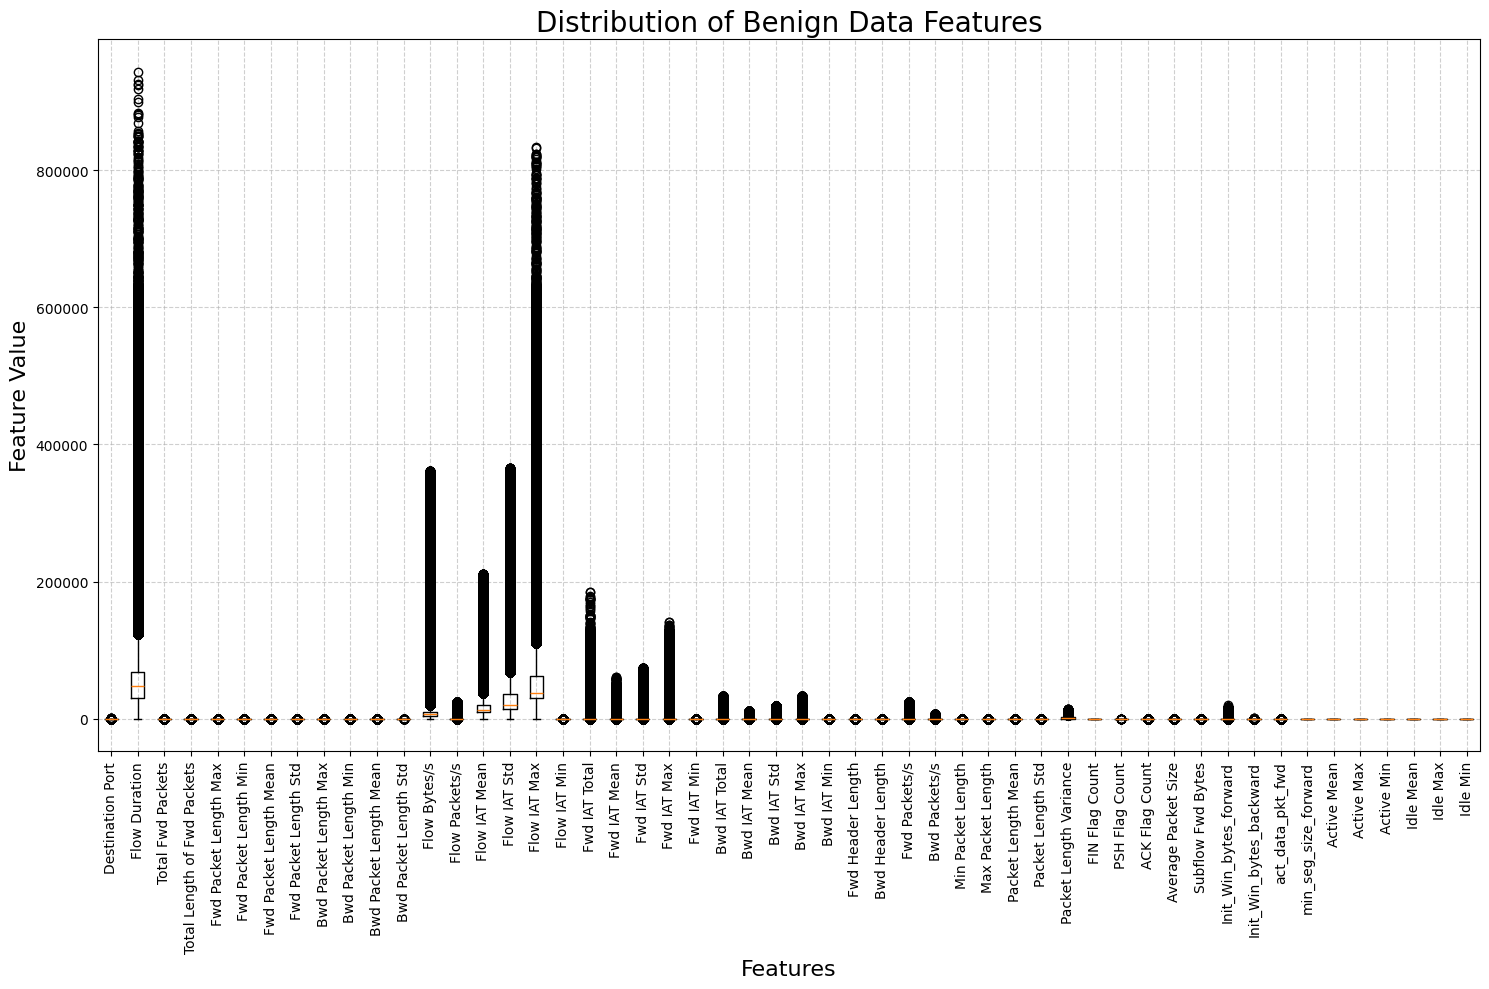

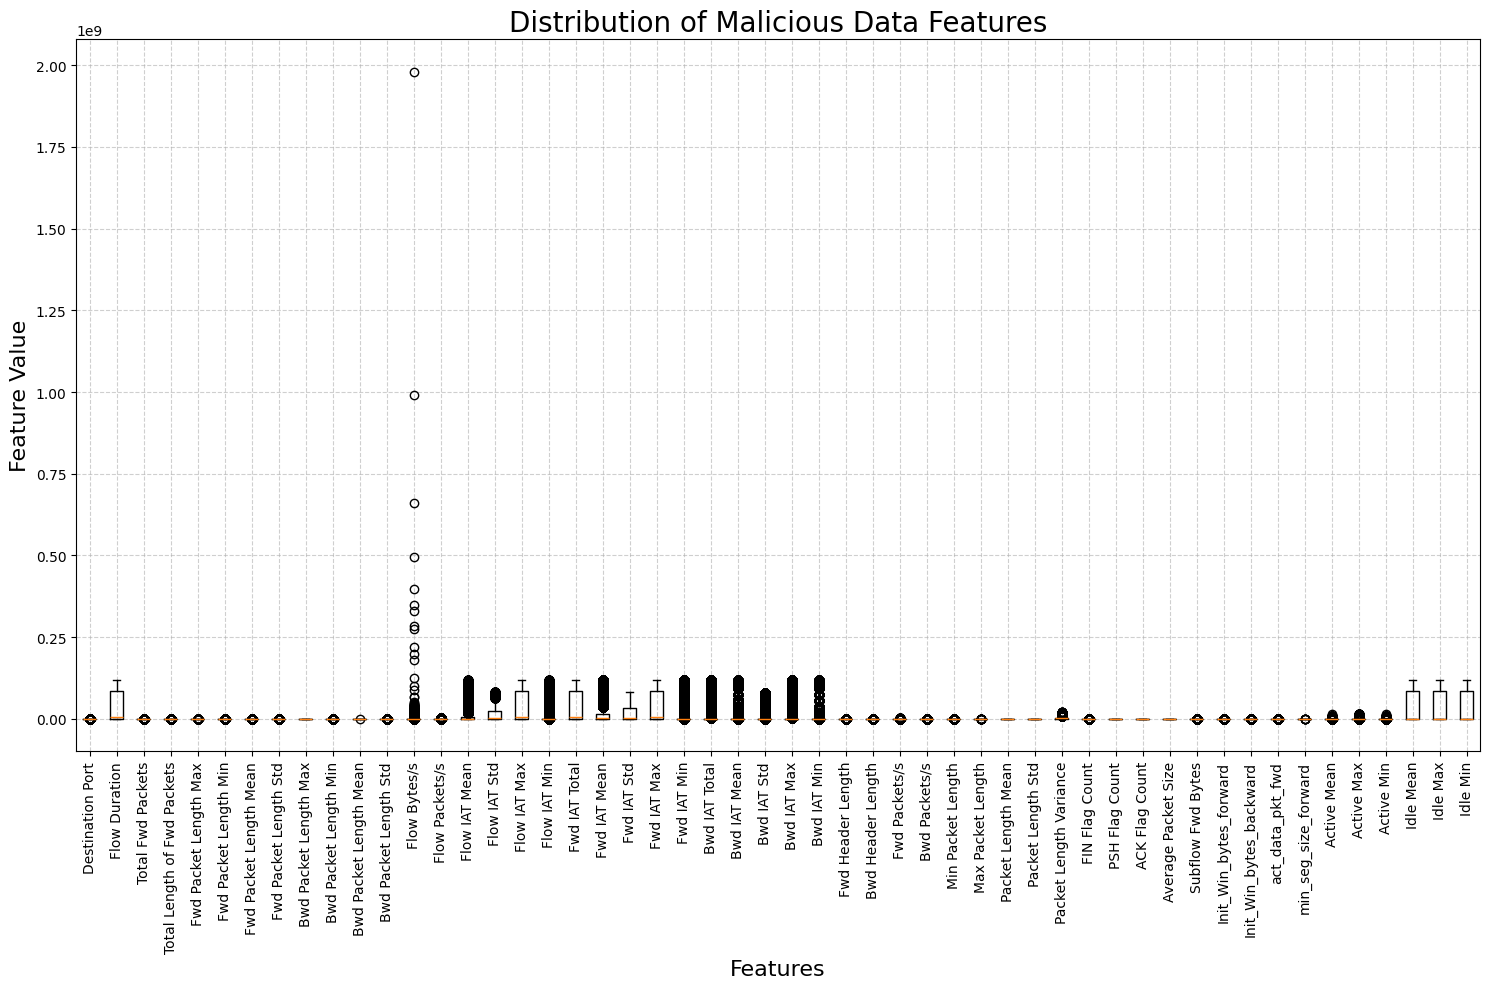

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Create the first figure for benign data
plt.figure(figsize=(15, 8))
plt.boxplot(X_benign)
plt.title('Distribution of Benign Data Features', fontsize=20)
plt.ylabel('Feature Value', fontsize=16)
plt.xlabel('Features', fontsize=16)
feature_names = X_benign.columns.tolist()
plt.xticks(range(1, len(feature_names) + 1), feature_names, rotation=90)  # start at 1
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Create the second figure for malicious data
plt.figure(figsize=(15, 8)) # Adjust figure size as needed
plt.boxplot(X_malicious)
plt.title('Distribution of Malicious Data Features', fontsize=20)
plt.ylabel('Feature Value', fontsize=16)
plt.xlabel('Features', fontsize=16)
feature_names = X_benign.columns.tolist()
plt.xticks(range(1, len(feature_names) + 1), feature_names, rotation=90)  # start at 1
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Visualise Split

Input Shapes -> Train: (185732, 52), Val: (32777, 52), Test: (519341, 52)
Labels distribution -> Train: [185732      0      0      0      0      0      0], Val: [32777     0     0     0     0     0     0], Test: [ 93647  90694   2143   9150 128014   1948 193745]


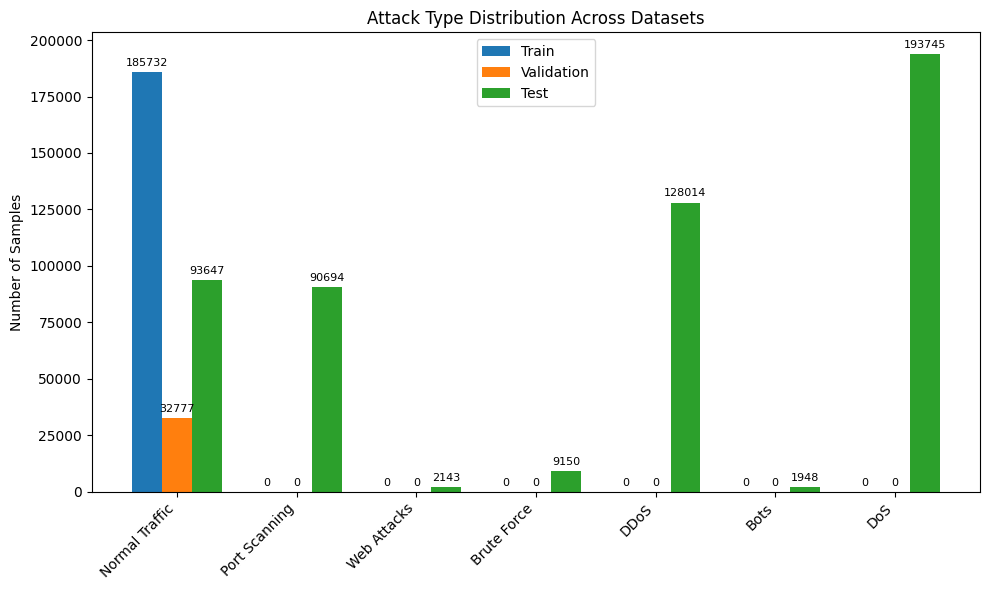

In [4]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Get the counts for each attack type in each dataset
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Get the number of unique attack types (based on the maximum index found)
num_attack_types = max(len(train_counts), len(val_counts), len(test_counts))

# Pad counts with zeros if some attack types are missing in a dataset split
train_counts = np.pad(train_counts, (0, num_attack_types - len(train_counts)), 'constant')
val_counts = np.pad(val_counts, (0, num_attack_types - len(val_counts)), 'constant')
test_counts = np.pad(test_counts, (0, num_attack_types - len(test_counts)), 'constant')


print(f"Labels distribution -> Train: {train_counts}, Val: {val_counts}, Test: {test_counts}")

# Data for plotting
datasets = ['Train', 'Validation', 'Test']
all_counts = np.array([train_counts, val_counts, test_counts])

# Get the original attack type names from the mapping
# Need to reverse the mapping to get names from labels
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(num_attack_types)]

x = np.arange(len(labels))  # the label locations for attack types
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6)) # Increase figure size

rects1 = ax.bar(x - width, all_counts[0], width, label='Train')
rects2 = ax.bar(x, all_counts[1], width, label='Validation')
rects3 = ax.bar(x + width, all_counts[2], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Attack Type Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right") # Rotate labels for better readability
ax.legend()

# Add value labels (optional, can make the plot cluttered with many categories)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.tight_layout()
plt.show()

Training set before normalisation

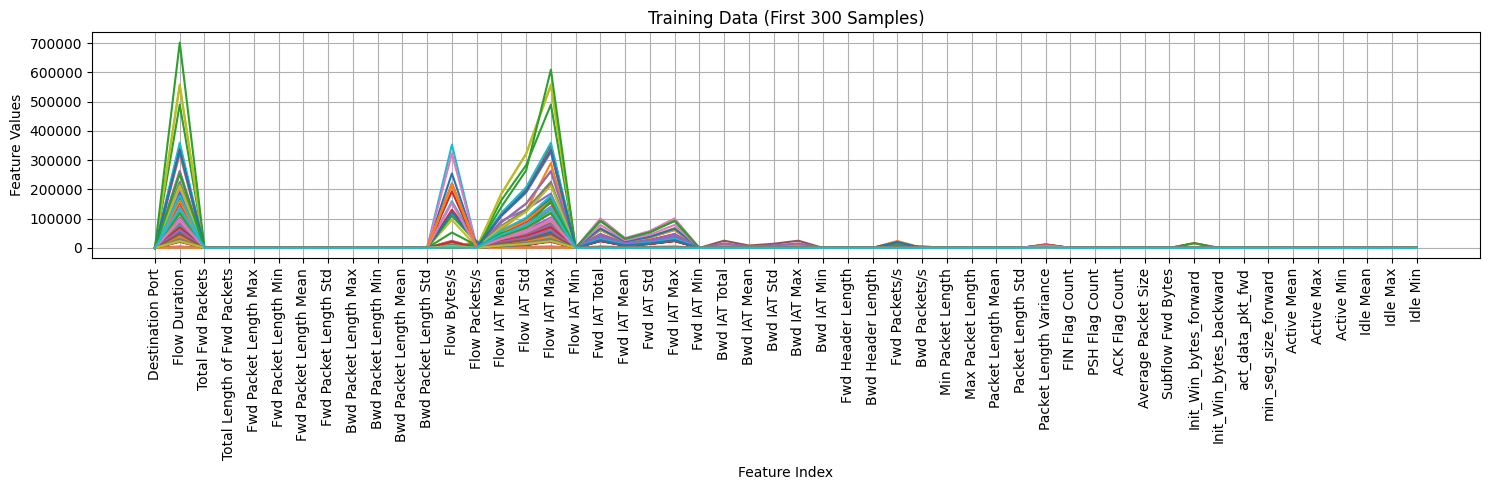

In [5]:
import matplotlib.pyplot as plt

# Use range for x-axis labels as X_train is a NumPy array
x_labels = range(X_train.shape[1])

plt.figure(figsize=(15, 5))  # Wider figure
# Plot the first 100 samples by transposing the data
plt.plot(x_labels, X_train[0:300].T)

plt.title("Training Data (First 300 Samples)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Values")
plt.grid(True)
# plt.legend() # Legend would be too cluttered with 100 lines

# Fix x-axis ticks
feature_names = X_benign.columns.tolist()
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.tight_layout()
plt.show()

Normalise the data:

In [6]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
# Initialize the scaler
#scaler = RobustScaler()
#scaler = StandardScaler()
scaler = MinMaxScaler()

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")


Shape of X_train after scaling: (185732, 52)
Shape of X_val after scaling: (32777, 52)
Shape of X_test after scaling: (519341, 52)


Training set after normalised

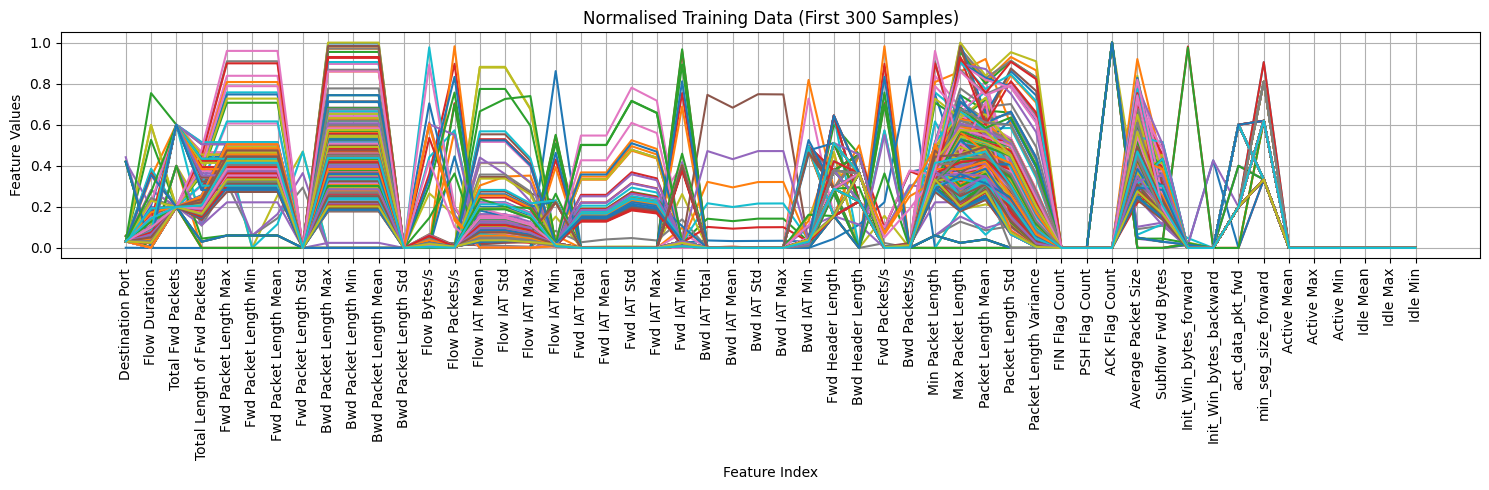

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train is a NumPy array after scaling
# If you still have the original DataFrame X_train_df before scaling,
# you can get the column names from there. Otherwise, we'll just use indices.

plt.figure(figsize=(15, 5)) # Wider figure

# Get the feature names from the original DataFrame before scaling
# Assuming X_benign is the original DataFrame before splitting and scaling
feature_names = X_benign.columns.tolist()


plt.plot(X_train[:300].T) # Transpose to plot samples as lines
plt.title("Normalised Training Data (First 300 Samples)") # Updated title
plt.xlabel("Feature Index")
plt.ylabel("Feature Values")
plt.grid(True)
# plt.legend() # Removed legend as it would be too cluttered

# Show feature indices
plt.xticks(range(len(feature_names)), feature_names, rotation=90)  # Rotate if labels are long
plt.tight_layout()
plt.show()

#Autoencoder model
An autoencoder model consists of two parts:
- **Encoder**: Responsible for compressing the input data into a lower-dimensional representation of the input data that captures the most important information.
- **Decoder**: Responsible for reconstructing the input data from the latent space representation. The decoder takes the latent space representation as input and produces a reconstructed version of the input data as output. The reconstructed data should be as similar as possible to the original input data.

- Advantages of autoencoders: Can be used to detect anomalies, unsupervised learning models (they do not require labeled data in training), easy to train and implement.
- Disadvantages of autoencoders: computationally expensive to train (especially for large datasets.), they are sensitive to the choice of hyperparameters, difficult to interpret.

Below is a simple autoencoder model with three layers in the encoder and three layers in the decoder. https://levelup.gitconnected.com/build-deep-autoencoders-model-for-anomaly-detection-in-python-a-complete-guide-a7d0ec0e688
https://medium.com/@ndhilani.simbine/how-i-built-a-real-time-anomaly-detection-system-for-enterprise-networks-using-python-and-machine-0078d8a26e84
https://medium.com/@walid.daboubi/malware-detection-using-deep-autoencoder-neural-network-wannacry-as-a-test-9d0125c925b2

In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, LeakyReLU, Dropout
import numpy as np # Import numpy

# Determine the input dimension from the scaled training data
autoencoder_input_dim = X_train.shape[1]
print(f"Autoencoder input dimension: {autoencoder_input_dim}")

autoencoder = Sequential([
    Input(shape=(autoencoder_input_dim,)),
    Dense(32, activation='relu'),                             # Encoder layer
    Dense(16, activation='relu'),                             # Encoder bottleneck
    Dense(8, activation='relu'),                              # Decoder bottleneck
    Dense(16, activation='relu'),                             # Decoder layer
    Dense(32, activation='relu'),                             # Decoder layer
    Dense(autoencoder_input_dim, activation='sigmoid')        # Output layer (same size as input)
])

# autoencoder = Sequential([
#     Input(shape=(autoencoder_input_dim,)),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
#     Dense(16, activation='relu'),  # bottleneck

#     Dense(32, activation='relu'),  # decoder layers usually without dropout
#     Dense(64, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(autoencoder_input_dim, activation='linear') #sigmoid
# ])

autoencoder.compile(optimizer='adam', loss='mse')

print(autoencoder.summary())

Autoencoder input dimension: 52


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 52)             │         1,716 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,764 (18.61 KB)

 Trainable params: 4,764 (18.61 KB)

 Non-trainable params: 0 (0.00 B)

None


# Train and test the model

Epoch 1/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0224 - val_loss: 0.0031
Epoch 2/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/10
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Training time: 92.73 seconds


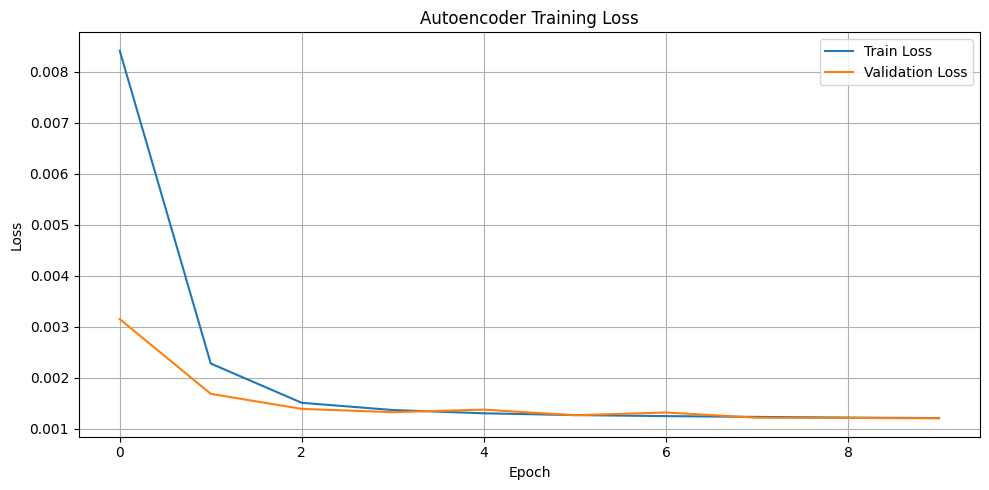

In [9]:
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping

# --- Early-stopping --- #TESTING
# https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e
# Early-stopping is a regularisation technique that prevents overfitting by stopping the training process when the model’s performance on the validation dataset starts degrading
# Stopping early reduces training time and computational costs

early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# Train the model with early stopping
start_time = timeit.default_timer()
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],
    verbose=1
)


# End timing
end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot training and validation loss graph
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#Test the model

Establish the threshold

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# --- Getting Threshold ----
# Get reconstructions and reconstruction errors of the training data
print("Getting average reconstruction error from the training data to determine a threshold...")
training_reconstructions = autoencoder.predict(X_train, verbose=0) # Added verbose=0 to reduce output during prediction

#TESTING:
#training_reconstruction_errors = np.mean(np.square(training_reconstructions - X_train), axis=1) #Mean Squared Error (MSE) per sample
training_reconstruction_errors = np.mean(np.abs(training_reconstructions - X_train), axis=1) #Mean Absolute Error (MAE) per sample

# Inspect first row
np.set_printoptions(precision=4, suppress=True)
print("original training data (first row):\n", X_train[0])
print("training_reconstructions (first row):\n", training_reconstructions[0])
print("training_reconstruction_errors (first row):\n", training_reconstruction_errors[0])


# --- Set the threshold -> Taking the average sum of reconstruction errors ---
threshold = np.mean(training_reconstruction_errors) #+ np.std(training_reconstruction_errors) # Choosing a threshold value that is one standard deviations above the mean.

print("\nAverge training reconstruction error:", np.mean(training_reconstruction_errors))
print("\nMedian training reconstruction error:", np.median(training_reconstruction_errors))
print(f"Threshold value: {threshold}")

Getting average reconstruction error from the training data to determine a threshold...
original training data (first row):
 [0.0318 0.0859 0.2    0.1717 0.3434 0.3434 0.3434 0.     0.2066 0.2066
 0.2066 0.     0.0058 0.0018 0.1262 0.1264 0.097  0.0139 0.     0.
 0.     0.     0.0164 0.0001 0.0002 0.     0.0001 0.0303 0.2889 0.2273
 0.0009 0.0039 0.3434 0.2066 0.2833 0.0748 0.0056 0.     0.     0.
 0.2833 0.1717 0.     0.     0.2    0.619  0.     0.     0.     0.
 0.     0.    ]
training_reconstructions (first row):
 [0.0269 0.0824 0.2013 0.1741 0.343  0.3432 0.3388 0.     0.2007 0.2022
 0.201  0.     0.0047 0.004  0.125  0.1233 0.0932 0.0004 0.0001 0.0002
 0.0001 0.0001 0.0298 0.     0.     0.     0.     0.0007 0.261  0.3326
 0.0022 0.0058 0.3386 0.204  0.2822 0.1106 0.0245 0.     0.     0.
 0.2837 0.1739 0.     0.     0.201  0.597  0.     0.     0.     0.
 0.     0.    ]
training_reconstruction_errors (first row):
 0.006296950284106009

Averge training reconstruction error: 0.0082307

Test the model on the test dataset

In [11]:
import tensorflow as tf
import numpy as np

# Get reconstructions and errors for test data
test_reconstructions = autoencoder.predict(X_test)

#TESTING
#test_reconstruction_errors = np.sum(np.square(test_reconstructions - X_test), axis=1)
#test_reconstruction_errors = np.mean(np.square(test_reconstructions - X_test), axis=1) # Reconstruction error: Mean Squared Error per sample
test_reconstruction_errors = np.mean(np.abs(test_reconstructions - X_test), axis=1) # Reconstruction error: Mean Squared Error per sample


# Display first row of data
np.set_printoptions(precision=4, suppress=True)
print("Original test data (first row):\n", X_test[0])
print("\nReconstructed test data (first row):\n", test_reconstructions[0])
print("\nReconstruction error (first row):\n", test_reconstruction_errors[0])

print("\nAverge test reconstruction error:", np.mean(test_reconstruction_errors))
print("\nMedian test reconstruction error:", np.median(test_reconstruction_errors))

# Identify anomalies (1 or 0)
y_pred = (test_reconstruction_errors > threshold).astype(int)
traffic_anomalies = np.where(y_pred == 1)[0]


16230/16230 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
Original test data (first row):
 [ 0.0587 -0.0001  1.2     0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     28.8823 -0.0003  0.     -0.0001  0.0093
  0.0001  0.      0.      0.      0.0082  0.      0.      0.      0.
  0.      1.1778  0.     28.8781  0.      0.      0.      0.      0.
  0.      0.      0.      1.      0.      0.      0.0151  0.      0.
  0.619   0.      0.      0.      0.      0.      0.    ]

Reconstructed test data (first row):
 [0.     0.     0.0001 0.     0.2663 0.     0.0003 0.     0.     0.
 0.     0.     1.     1.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.9844 0.
 1.     0.9933 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     1.     0.     0.     0.     0.
 0.     0.    ]

Reconstruction error (first row):
 1.170890508749355

Averge test reconstruction error: 1677115.0126261725

Median test rec

Plot normal and anomaly loss

In [12]:
# import matplotlib.pyplot as plt

# # Graphical representation of training set loss:
# train_loss = tf.keras.losses.mae(training_reconstructions, X_train)# Mean absolute error and plot it in form of a histogram

# # Plot
# plt.figure(figsize=(5, 5))
# plt.hist(train_loss, bins=50,label='normal', color='blue', alpha= 0.5)
# plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Graphical representation of test set loss:
# test_loss = tf.keras.losses.mae(test_reconstructions, X_test)# Mean absolute error and plot it in form of a histogram
# # Plot
# plt.figure(figsize=(5, 5))
# plt.hist(train_loss, bins=50,label='anomaly', color='blue', alpha= 0.5)
# plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Evaluate model predictions against ground truth

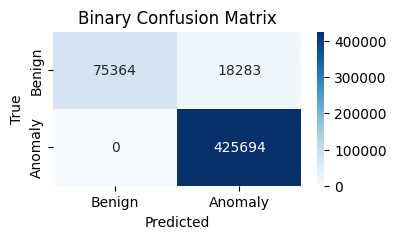


Accuracy:
sklearn Accuracy: 0.9647957700239341

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.80      0.89     93647
     Anomaly       0.96      1.00      0.98    425694

    accuracy                           0.96    519341
   macro avg       0.98      0.90      0.94    519341
weighted avg       0.97      0.96      0.96    519341


Anomaly Detection Metrics:
True Positives (Anomalies correctly detected): 425694
True Negatives (Normal Traffic correctly identified): 75364
False Positives (Normal Traffic misclassified as Anomaly): 18283
False Negatives (Anomalies missed): 0

Percentage of Anomalies Detected: 100.00%
Percentage of Normal Traffic Misclassified (False Positive Rate): 19.52%


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test to binary: 0 = Normal, 1 = Anomaly
y_test_binary = (y_test != 0).astype(int)

# --- Confusion matrix ---
cm = confusion_matrix(y_test_binary, y_pred)

# --- Heatmap ---
# Labels for the binary confusion matrix
binary_labels = ['Benign', 'Anomaly']

# Plot heatmap
plt.figure(figsize=(4, 2)) # Adjust figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=binary_labels, yticklabels=binary_labels)
plt.title("Binary Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Accuracy scores
print("\nAccuracy:")
print("sklearn Accuracy:", accuracy_score(y_test_binary, y_pred))

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
# target_names should be the actual class names for binary classification
report = classification_report(y_test_binary, y_pred, target_names=binary_labels, output_dict=True)
print(classification_report(y_test_binary, y_pred, target_names=binary_labels))

# --- Custom Metrics for Anomaly Detection ---
# From the confusion matrix:
tn, fp, fn, tp = cm.ravel() # Unpack confusion matrix values

print("\nAnomaly Detection Metrics:")
print(f"True Positives (Anomalies correctly detected): {tp}")
print(f"True Negatives (Normal Traffic correctly identified): {tn}")
print(f"False Positives (Normal Traffic misclassified as Anomaly): {fp}")
print(f"False Negatives (Anomalies missed): {fn}")

# Calculate percentages
total_anomalies = tp + fn
total_normal = tn + fp

percentage_anomalies_detected = (tp / total_anomalies) * 100 if total_anomalies > 0 else 0
percentage_normal_misclassified = (fp / total_normal) * 100 if total_normal > 0 else 0

print(f"\nPercentage of Anomalies Detected: {percentage_anomalies_detected:.2f}%")
print(f"Percentage of Normal Traffic Misclassified (False Positive Rate): {percentage_normal_misclassified:.2f}%")

# Input Vs Reconstructed Output

In [14]:
#print(y_test[:40])

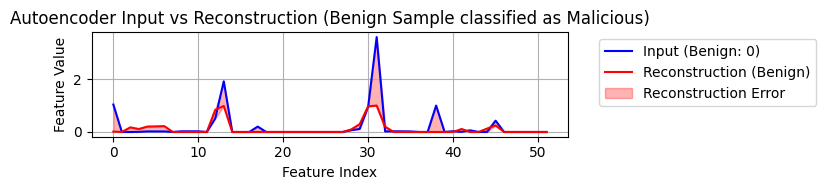

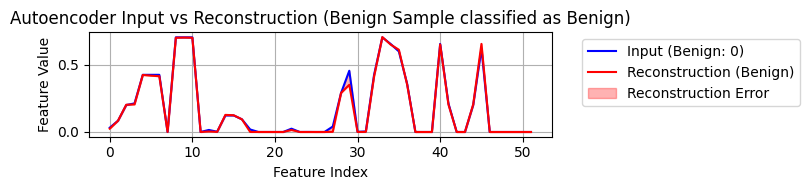

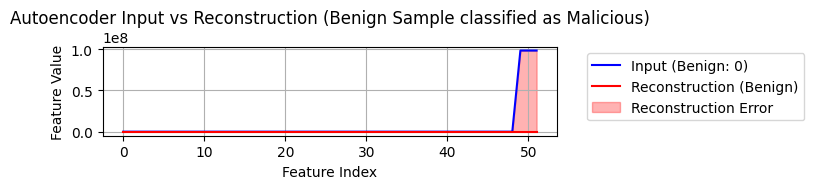

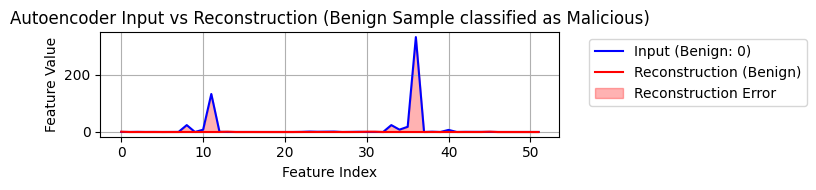

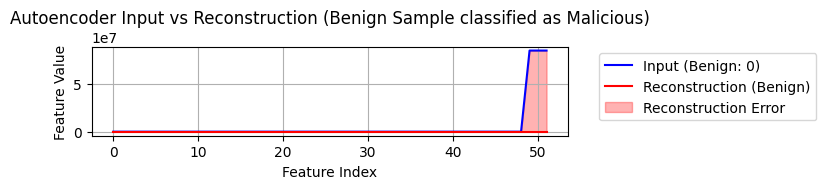

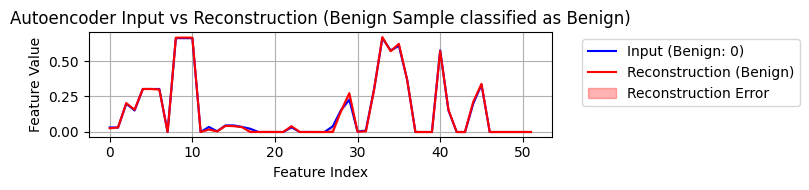

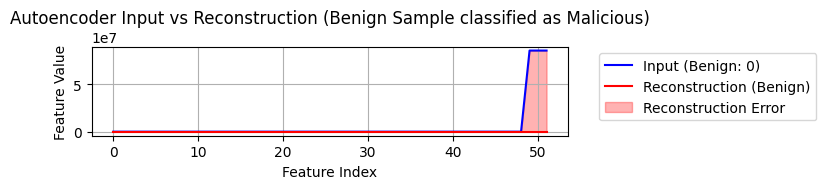

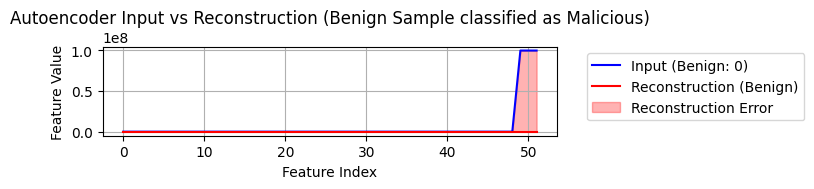

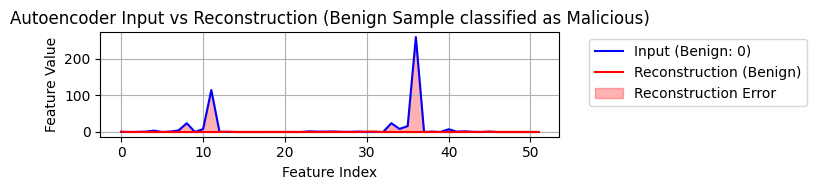

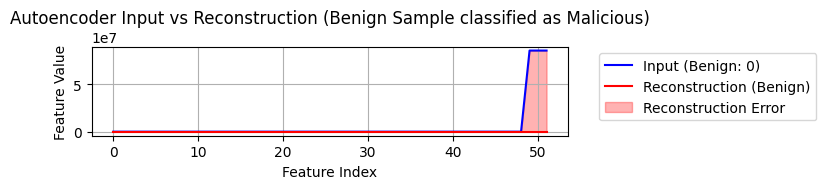

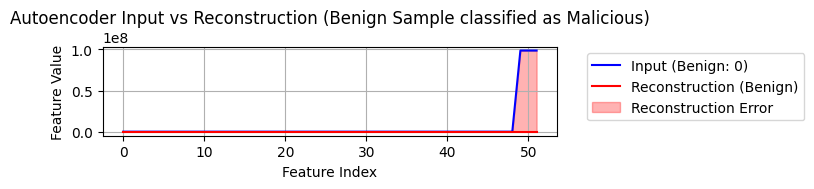

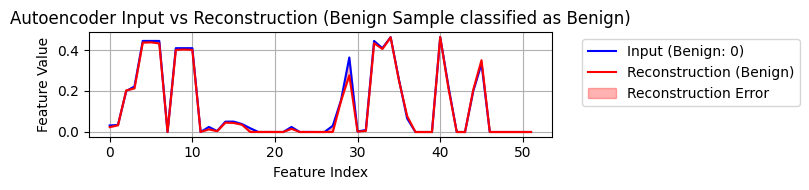

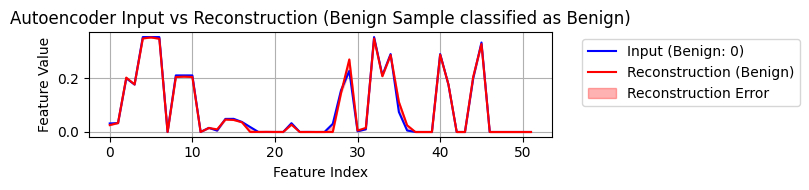

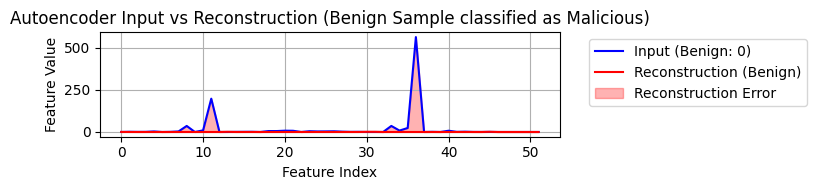

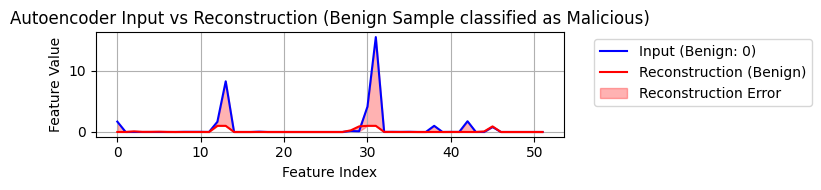

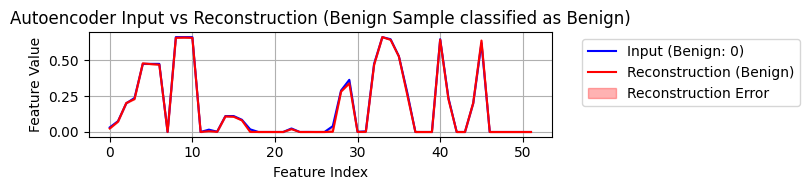

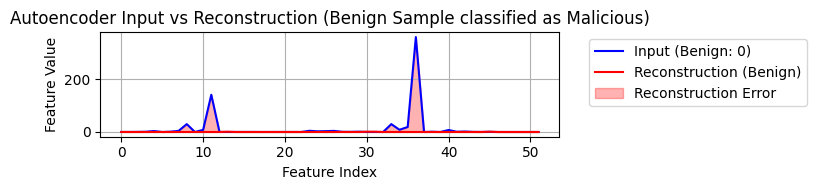

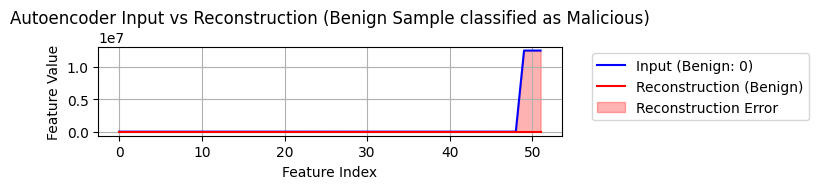

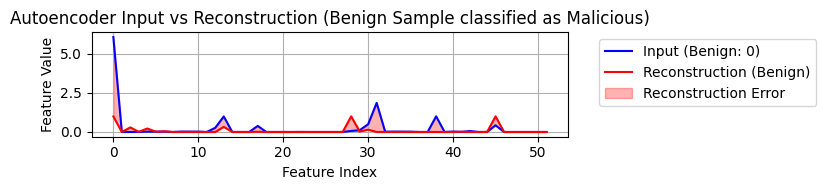

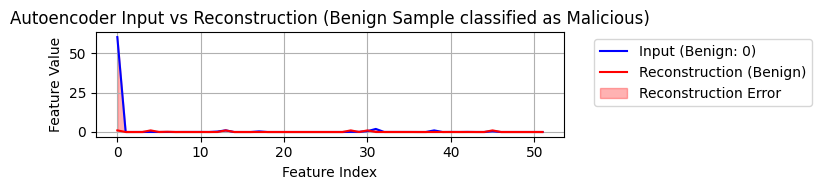

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Find the indexs of all the benign and a malicious sample in the test set
benign_sample_indices = y_test[y_test == 0].index #list of indices that link to a benign sample in the test set


# Ensure there are benign and malicious samples in the test set before proceeding
if len(benign_sample_indices) > 0:
    benign_sample_idx_in_test_set = benign_sample_indices[0] # Get the first benign sample indice from the test set
else:
    benign_sample_idx_in_test_set = None
    print("No benign samples found in the test set.")


# --- Plot Benign Sample ---
if benign_sample_idx_in_test_set is not None:

  i = 0
  for i in range(20):
      # Plots
      plt.figure(figsize=(8, 2))
      plt.plot(X_test[benign_sample_indices[i]], label=f'Input (Benign: {y_test[benign_sample_indices[i]]})', color='blue')
      plt.plot(test_reconstructions[benign_sample_indices[i]], label='Reconstruction (Benign)', color='red')

      # Fill in error gap
      plt.fill_between(np.arange(len(X_test[benign_sample_indices[i]])),
                      np.minimum(X_test[benign_sample_indices[i]], test_reconstructions[benign_sample_indices[i]]),
                      np.maximum(X_test[benign_sample_indices[i]], test_reconstructions[benign_sample_indices[i]]),
                      color='red', alpha=0.3, label='Reconstruction Error')

      plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
      plt.title(f"Autoencoder Input vs Reconstruction (Benign Sample classified as {'Malicious' if y_pred[benign_sample_indices[i]] != 0 else 'Benign'})")
      plt.xlabel("Feature Index")
      plt.ylabel("Feature Value")
      plt.grid(True)
      plt.tight_layout()
      plt.show()

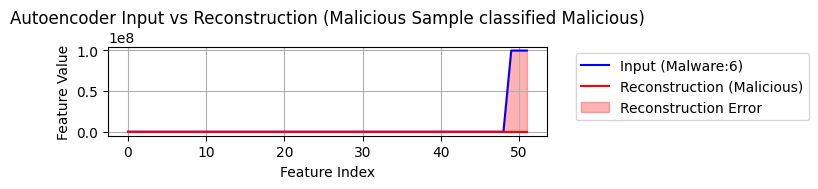

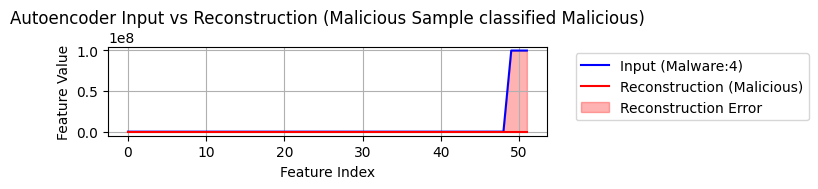

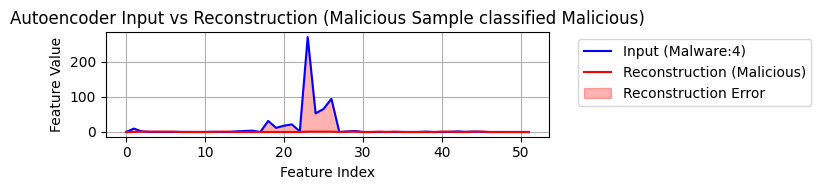

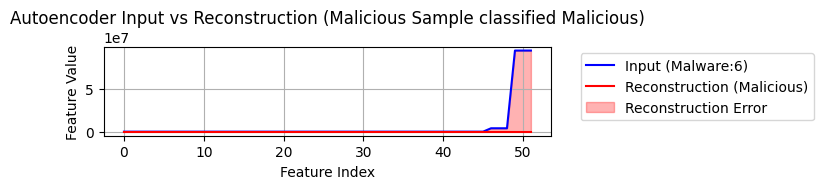

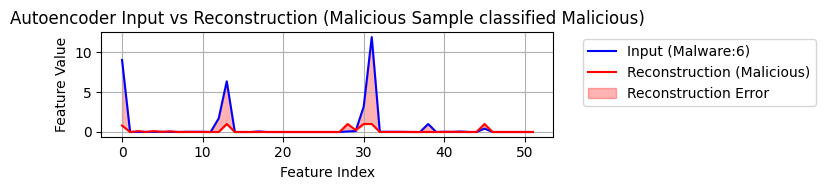

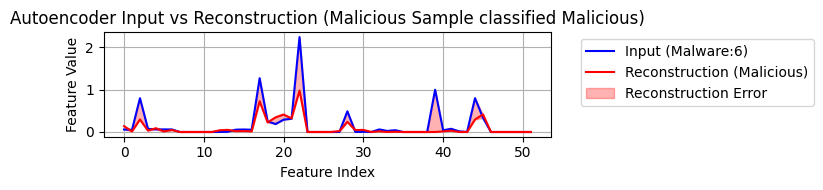

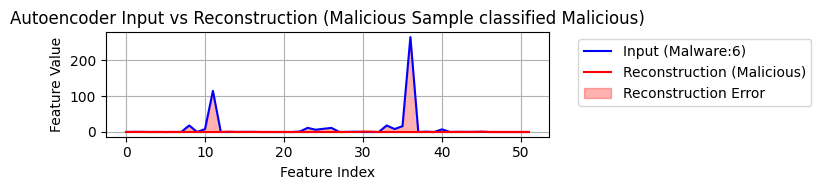

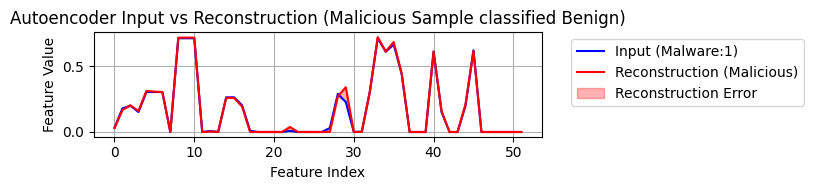

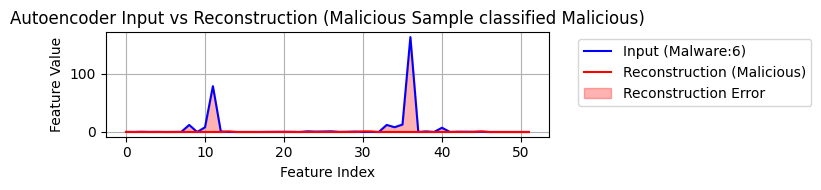

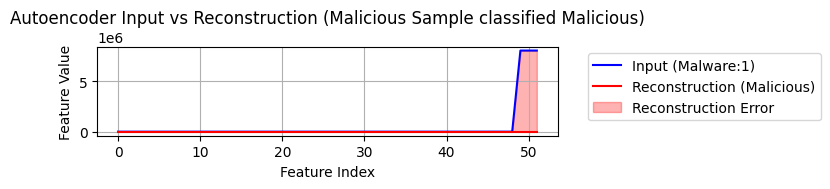

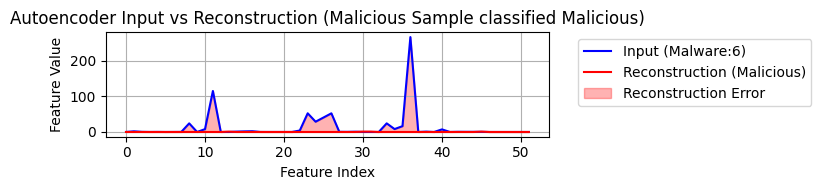

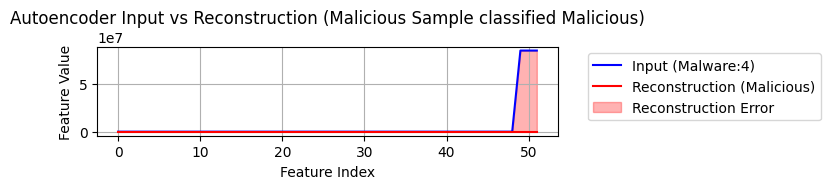

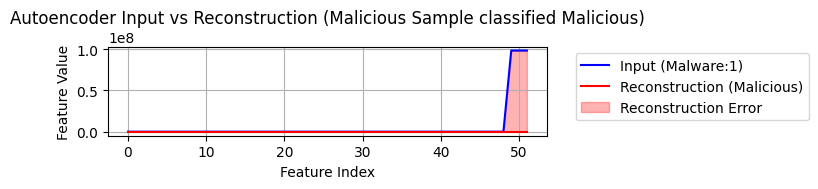

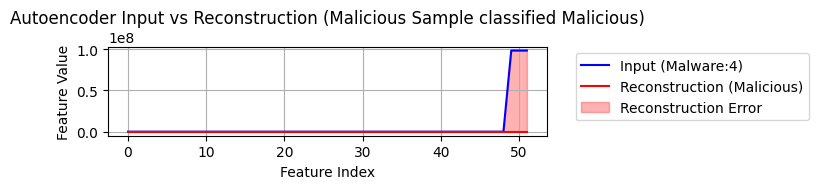

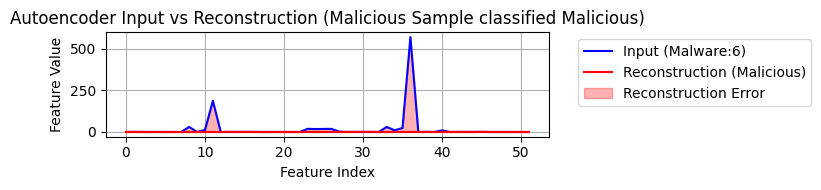

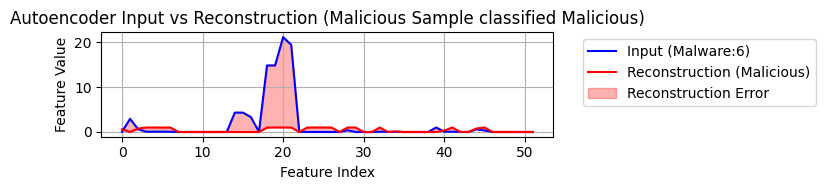

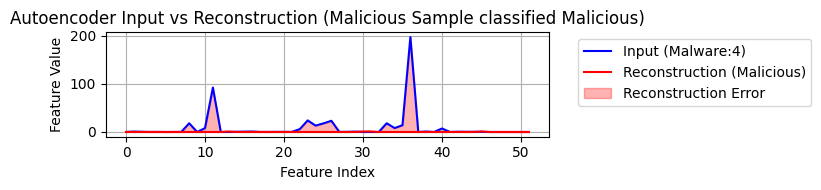

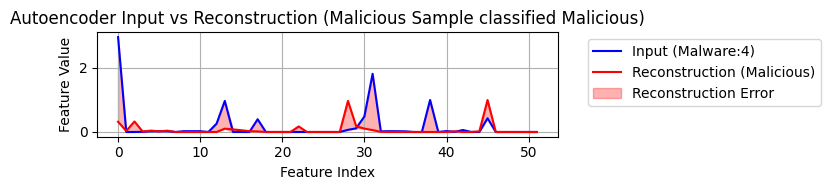

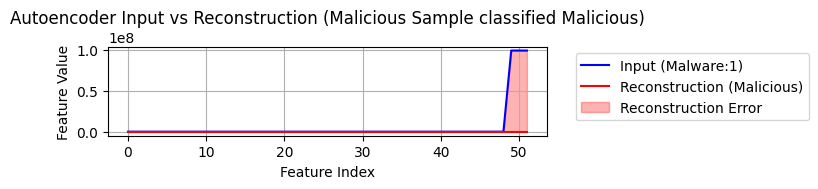

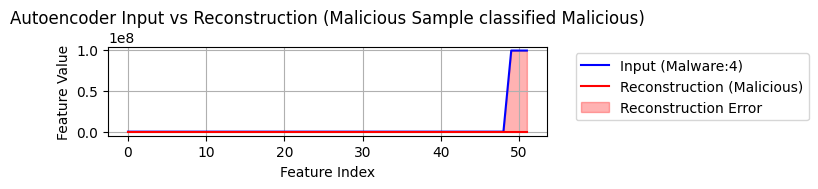

In [22]:
import matplotlib.pyplot as plt
import numpy as np

malicious_sample_indices = y_test[y_test != 0].index

if len(malicious_sample_indices) > 0:
    malicious_sample_idx_in_test_set = malicious_sample_indices[0] # Get the first malicious sample indice from the test set
else:
    malicious_sample_idx_in_test_set = None
    print("No malicious samples found in the test set.")

# --- Plot Malicious Sample ---
if malicious_sample_idx_in_test_set is not None:

  i = 0
  for i in range(20):
    #Plot
    plt.figure(figsize=(8, 2))
    plt.plot(X_test[malicious_sample_indices[i]], label=f'Input (Malware:{y_test[malicious_sample_indices[i]]})', color='blue')
    plt.plot(test_reconstructions[malicious_sample_indices[i]], label='Reconstruction (Malicious)', color='red')

    # Error band
    plt.fill_between(np.arange(len(X_test[malicious_sample_indices[i]])),
                      np.minimum(X_test[malicious_sample_indices[i]], test_reconstructions[malicious_sample_indices[i]]),
                      np.maximum(X_test[malicious_sample_indices[i]], test_reconstructions[malicious_sample_indices[i]]),
                      color='red', alpha=0.3, label='Reconstruction Error')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
    plt.title(f"Autoencoder Input vs Reconstruction (Malicious Sample classified {'Malicious' if y_pred[malicious_sample_indices[i]] != 0 else 'Benign'})")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#Save Best AE

In [17]:

# import os

# # Define the directory path
# save_dir = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian\'s Models'

# # Create the directory if it doesn't exist
# os.makedirs(save_dir, exist_ok=True)

# # Save the trained model
# model_path = os.path.join(save_dir, 'Best_AE.keras')
# autoencoder.save(model_path)  # Native Keras format
# print(f"Model saved as {model_path}")


#Malware Classifier


*   Softmax classifier
*   XGBoost
*   CNN?


In [18]:
# import numpy as np

# class SoftmaxClassifier:
#     def __init__(self, input_dim, num_classes, learning_rate=0.01):
#         self.input_dim = input_dim
#         self.num_classes = num_classes
#         self.learning_rate = learning_rate
#         self.weights = np.random.randn(input_dim, num_classes) * 0.01
#         self.bias = np.zeros((1, num_classes))

#     def softmax(self, z):
#         exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability
#         return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

#     def cross_entropy_loss(self, y_true, y_pred):
#         m = y_true.shape[0]
#         log_likelihood = -np.log(y_pred[range(m), y_true])
#         loss = np.sum(log_likelihood) / m
#         return loss

#     def one_hot(self, y):
#         one_hot_labels = np.zeros((y.size, self.num_classes))
#         one_hot_labels[np.arange(y.size), y] = 1
#         return one_hot_labels

#     def train(self, X, y, epochs=100):
#         m = X.shape[0]
#         for epoch in range(epochs):
#             # Forward pass
#             logits = np.dot(X, self.weights) + self.bias
#             probs = self.softmax(logits)

#             # Loss (optional print)
#             loss = self.cross_entropy_loss(y, probs)
#             if epoch % 10 == 0:
#                 print(f"Epoch {epoch}: Loss = {loss:.4f}")

#             # Backpropagation
#             y_one_hot = self.one_hot(y)
#             gradient_logits = (probs - y_one_hot) / m

#             grad_weights = np.dot(X.T, gradient_logits)
#             grad_bias = np.sum(gradient_logits, axis=0, keepdims=True)

#             # Gradient descent update
#             self.weights -= self.learning_rate * grad_weights
#             self.bias -= self.learning_rate * grad_bias

#     def predict(self, X):
#         logits = np.dot(X, self.weights) + self.bias
#         probs = self.softmax(logits)
#         return np.argmax(probs, axis=1)


Get data for classiifer training

Training the Classifier

In [19]:
# input_dim = X_train_malware.shape[1]
# num_classes = len(np.unique(y_train_malware))

# classifier = SoftmaxClassifier(input_dim=input_dim, num_classes=num_classes)
# classifier.train(X_train_malware, y_train_malware, epochs=10)


Predicting Malware Class for Anomalies

In [20]:
# y_pred_classes = classifier.predict(X_anomalies)

# # Optionally evaluate
# from sklearn.metrics import classification_report
# print(classification_report(y_anomalies, y_pred_classes))
